# Lyft Data Challenge
## Team BowTieBoys
#### Jacob Lebowitz
#### Tiger Gamble

# Preproccesing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import xgboost as xgb

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Driver data
driver_df = pd.read_csv('driver_ids.csv')
driver_df['driver_onboard_date'] =  pd.to_datetime(driver_df['driver_onboard_date'])
driver_df.sort_values(by='driver_onboard_date', ascending=True, inplace=True)

# Ride data
ride_df = pd.read_csv('ride_ids.csv')
# Converting ride distance from meters to miles
ride_df['ride_distance'] = ride_df['ride_distance'].apply(lambda x: x * 0.000621371192)
# Converting ride duration from seconds to minutes
ride_df['ride_duration'] = ride_df['ride_duration'].apply(lambda x: x / 60)

# Timestamp data
timestamps_df = pd.read_csv('ride_timestamps.csv')
timestamps_df['timestamp'] =  pd.to_datetime(timestamps_df['timestamp'])

In [3]:
# 937 unique drivers
# all drivers have onboard dates
driver_df.head()

,driver_id,driver_onboard_date
432,72ca99bb6667024a23e1f68904b06fd0,2016-03-28
907,f86eb77e1cefe28e9f0e9d3775fae261,2016-03-28
107,1e9b964b3e3d0289794289579269247a,2016-03-28
895,f1b4411717c78f67380366c2a16a4d1e,2016-03-28
889,f0df79d10df44f18742682108b17f60a,2016-03-28


In [4]:
# 937 unique
# 193,502 unqiue Rides
ride_df.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,100


In [5]:
# Timestamp is missing one datapoint
# Need to delete the entire ride because of missing timestamp for event
# 194,081 unique rides
# 970,405 different event entries
timestamps_df.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [6]:
# Finding the ride where timestamp has a missing value
timestamps_df[timestamps_df['timestamp'].isnull()]

,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


In [7]:
# Removing that ride from the dataframe
timestamps_df = timestamps_df[timestamps_df['ride_id'] != '72f0fa0bd86800e9da5c4dced32c8735']

In [8]:
# 194,080 different rides 
# 970,400 different event entries
timestamps_df.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [9]:
# Merging timestamps_df and ride_df while removing all rides that are not 1:1 matches
all_ride_data_df = timestamps_df.merge(ride_df, on='ride_id', how='inner') 

In [10]:
# 844 drivers
# 924,090 different event entries
# 184,818 different rides
all_ride_data_df.head()

,ride_id,event,timestamp,driver_id,ride_distance,ride_duration,ride_prime_time
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0


In [11]:
# Merging ride_df and driver_df while removing all drivers that are not 1:1 matches 
# Building total ride duration, distance, and prime time colums as well
all_driver_data_df = ride_df.copy() 

all_driver_data_df = all_driver_data_df.merge(driver_df, on='driver_id', how='inner')
all_driver_data_df['total_distance'] = all_driver_data_df.groupby('driver_id')['ride_distance'].transform('sum')
all_driver_data_df['total_duration'] = all_driver_data_df.groupby('driver_id')['ride_duration'].transform('sum')
all_driver_data_df['total_prime_time'] = all_driver_data_df.groupby('driver_id')['ride_prime_time'].transform('sum')
all_driver_data_df.drop(['ride_id', 'ride_distance', 'ride_duration', 'ride_prime_time'], axis=1, inplace=True)
all_driver_data_df = all_driver_data_df.drop_duplicates('driver_id')

In [12]:
# 854 unique drivers
all_driver_data_df.head()

,driver_id,driver_onboard_date,total_distance,total_duration,total_prime_time
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,1081.364208,3687.300000,5375
277,007f0389f9c7b03ef97098422f902e62,2016-03-29,73.030378,341.616667,625
308,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,167.554606,486.750000,675
342,0152a2f305e71d26cc964f8d4411add9,2016-04-23,914.185531,2908.683333,2050
533,01674381af7edd264113d4e6ed55ecda,2016-04-29,1940.942396,5957.383333,4700


In [13]:
# Need to remove driver_ids that are not a 1:1 match between key dataframes
temp_df = all_driver_data_df.merge(all_ride_data_df, on='driver_id', how='inner')
important_driver_ids = temp_df['driver_id'].unique()

# create new dataframes that have only the 1:1 matches
updated_driver_data_df = all_driver_data_df[all_driver_data_df['driver_id'].isin(important_driver_ids)]
updated_ride_data_df = all_ride_data_df[all_ride_data_df['driver_id'].isin(important_driver_ids)]

In [14]:
# 837 unique drivers
updated_driver_data_df.head()

,driver_id,driver_onboard_date,total_distance,total_duration,total_prime_time
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,1081.364208,3687.300000,5375
277,007f0389f9c7b03ef97098422f902e62,2016-03-29,73.030378,341.616667,625
308,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,167.554606,486.750000,675
342,0152a2f305e71d26cc964f8d4411add9,2016-04-23,914.185531,2908.683333,2050
533,01674381af7edd264113d4e6ed55ecda,2016-04-29,1940.942396,5957.383333,4700


In [15]:
# 837 unique drivers
# 921,040 unique event entries
# 184,208 unique rides 
updated_ride_data_df.head()

,ride_id,event,timestamp,driver_id,ride_distance,ride_duration,ride_prime_time
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0


# Feature Engineering

In [16]:
# Holds how many rides driven for a driver

rides_driven = updated_ride_data_df.groupby('driver_id')['ride_id'].nunique()
updated_driver_data_df['rides_given'] = rides_driven.values

# Finds average ride distance in Miles

updated_driver_data_df['avg_ride_distance'] = updated_driver_data_df['total_distance'] / updated_driver_data_df['rides_given']

# Finds average duration in Minutes

updated_driver_data_df['avg_ride_duration'] = updated_driver_data_df['total_duration'] / updated_driver_data_df['rides_given']

# Get first ride and last drive of each rider

first_ride_date = updated_ride_data_df.groupby('driver_id')['timestamp'].min()
first_ride_date = first_ride_date.to_frame().rename(columns={'timestamp': 'first_ride_date'})
updated_driver_data_df = updated_driver_data_df.merge(first_ride_date, on='driver_id', how='inner')

last_ride_date = updated_ride_data_df.groupby('driver_id')['timestamp'].max()
last_ride_date = last_ride_date.to_frame().rename(columns={'timestamp': 'last_ride_date'})
updated_driver_data_df = updated_driver_data_df.merge(last_ride_date, on='driver_id', how='inner')

# Get the maximum days the driver could have drived for

last_ride_in_data = datetime.strptime('2016-06-27  00:50', '%Y-%m-%d %H:%M')
maximum_drive_days = last_ride_in_data - updated_driver_data_df['driver_onboard_date']
updated_driver_data_df['maximum_drive_days_int'] = maximum_drive_days.dt.days

# Get days till first ride since sign up (shows sign of excitemnet or either need to drive possibly)

days_till_first_ride = updated_driver_data_df['first_ride_date'] - updated_driver_data_df['driver_onboard_date'].values
updated_driver_data_df['days_till_first_ride'] = days_till_first_ride

# Getting drivers days of being a lyft driver

days_being_a_lyft_driver = updated_driver_data_df['last_ride_date'] - updated_driver_data_df['driver_onboard_date'].values
updated_driver_data_df['days_being_a_lyft_driver'] = days_being_a_lyft_driver

days_being_a_lyft_driver = updated_driver_data_df['last_ride_date'] - updated_driver_data_df['driver_onboard_date'].values
updated_driver_data_df['days_being_a_lyft_driver_int'] = days_being_a_lyft_driver.dt.days

In [17]:
updated_driver_data_df.head()

,driver_id,driver_onboard_date,total_distance,total_duration,total_prime_time,rides_given,avg_ride_distance,avg_ride_duration,first_ride_date,last_ride_date,maximum_drive_days_int,days_till_first_ride,days_being_a_lyft_driver,days_being_a_lyft_driver_int
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,1081.364208,3687.300000,5375,277,3.903842,13.311552,2016-03-29 18:46:50,2016-06-23 10:29:53,90,0 days 18:46:50,86 days 10:29:53,86
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,73.030378,341.616667,625,31,2.355819,11.019892,2016-03-29 22:28:28,2016-06-22 13:28:38,90,0 days 22:28:28,85 days 13:28:38,85
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,167.554606,486.750000,675,34,4.928077,14.316176,2016-04-05 10:54:51,2016-06-12 20:30:38,83,0 days 10:54:51,68 days 20:30:38,68
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,914.185531,2908.683333,2050,191,4.786312,15.228709,2016-04-25 15:59:20,2016-06-26 10:36:13,65,2 days 15:59:20,64 days 10:36:13,64
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,1940.942396,5957.383333,4700,375,5.175846,15.886356,2016-04-29 07:50:40,2016-06-24 13:27:38,59,0 days 07:50:40,56 days 13:27:38,56


In [18]:
# Lyft Pricing
serivce_fee = 1.75
base_fare = 2.00
mile = 1.15
minute = .22
min_fare = 5.00
max_fare = 400.00

# Calculations
cost_per_mile = updated_ride_data_df['ride_distance'] * mile
cost_per_minute = updated_ride_data_df['ride_duration'] * minute
prime_time_percent = updated_ride_data_df['ride_prime_time']/100


# Get ride fare for every ride
cleaned_ride_fares = []
prime_time_fee = (base_fare + cost_per_mile + cost_per_minute) * prime_time_percent
ride_fares = base_fare + serivce_fee + prime_time_fee + cost_per_mile + cost_per_minute
lyfts_value_per_drive = ((base_fare + prime_time_fee + cost_per_mile + cost_per_minute)*.20) + serivce_fee
driver_value_per_drive = ((base_fare + prime_time_fee + cost_per_mile + cost_per_minute)*.80)

# Loop to catch for min and max fare prices
for fare in ride_fares:
    if fare >= 400.00:
        cleaned_ride_fares.append(400.00)
    elif fare <= 5.00:
        cleaned_ride_fares.append(5.00)
    else:
        cleaned_ride_fares.append(fare)
        
updated_ride_data_df['ride_fare'] = cleaned_ride_fares
updated_ride_data_df['lyfts_value_per_drive'] = lyfts_value_per_drive
updated_ride_data_df['driver_value_per_drive'] = driver_value_per_drive

In [19]:
updated_ride_data_df.head()

,ride_id,event,timestamp,driver_id,ride_distance,ride_duration,ride_prime_time,ride_fare,lyfts_value_per_drive,driver_value_per_drive
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871


In [20]:
# Get total money made for each driver

gb = updated_ride_data_df.groupby('event').get_group('requested_at')[['driver_id', 'ride_fare']]
total_money_made = gb.groupby('driver_id')['ride_fare'].sum().values
updated_driver_data_df['total_money_made'] = total_money_made

# Get average number of drives per week 

one_week = pd.Timedelta(days=7)
avg_rides_in_week = updated_driver_data_df['rides_given'] / (updated_driver_data_df['days_being_a_lyft_driver'] / one_week)
updated_driver_data_df['avg_rides_in_week'] = avg_rides_in_week

# Gets average value that lyft makes per ride 

gb = updated_ride_data_df.groupby('event').get_group('requested_at')[['driver_id', 'lyfts_value_per_drive']]
total_money_made = gb.groupby('driver_id')['lyfts_value_per_drive'].sum().values
updated_driver_data_df['avg_lyft_value_per_ride'] = total_money_made / updated_driver_data_df['rides_given']

# Gets average value that the driver makes per ride 

gb = updated_ride_data_df.groupby('event').get_group('requested_at')[['driver_id', 'driver_value_per_drive']]
total_money_made = gb.groupby('driver_id')['driver_value_per_drive'].sum().values
updated_driver_data_df['avg_driver_value_per_ride'] = total_money_made / updated_driver_data_df['rides_given']

# Gets total money made for a driver

gb = updated_ride_data_df.groupby('event').get_group('requested_at')[['driver_id', 'driver_value_per_drive']]
total_money_made = gb.groupby('driver_id')['driver_value_per_drive'].sum().values
updated_driver_data_df['total_driver_value'] = total_money_made 

# Gets total money made for lyft

gb = updated_ride_data_df.groupby('event').get_group('requested_at')[['driver_id', 'lyfts_value_per_drive']]
total_money_made = gb.groupby('driver_id')['lyfts_value_per_drive'].sum().values
updated_driver_data_df['total_lyft_value'] = total_money_made 

In [22]:
# Building dataframe for all rides

temp_df1 = updated_ride_data_df.copy()

main_ride_data_df = temp_df1.loc[updated_ride_data_df['event'] == 'requested_at']
main_ride_data_df.drop('event', axis=1, inplace=True)

# Get time diference between requested ride and accepted ride

requested_timestamps = updated_ride_data_df.groupby('event').get_group('requested_at')['timestamp'].values
accepted_at_timestamps = updated_ride_data_df.groupby('event').get_group('accepted_at')['timestamp'].values

time_between_request_accept = (abs((requested_timestamps - accepted_at_timestamps)) / 1_000_000_000.0).astype(int) / 60

main_ride_data_df['minutes_between_request_accept'] = time_between_request_accept


# Get time diference between accepted ride and arrived at

arrived_at_timestamps = updated_ride_data_df.groupby('event').get_group('arrived_at')['timestamp'].values

time_between_accept_arrive = (abs((accepted_at_timestamps - arrived_at_timestamps)) / 1_000_000_000.0).astype(int) / 60

main_ride_data_df['minutes_between_accept_arrive'] = time_between_accept_arrive


# Gets average time spent driving per mile

summed_distance = main_ride_data_df['ride_distance'].sum()
summed_duration = main_ride_data_df['ride_duration'].sum()

avg_mile_per_minute = summed_distance /summed_duration

# Projected miles driven from accepted_at to arrived_at
main_ride_data_df['miles_from_accepted_to_arrived'] = main_ride_data_df['minutes_between_accept_arrive'] * avg_mile_per_minute 

# Percentage of prime rides
gb = main_ride_data_df.groupby('driver_id')

prime_time_rides = []
for driver in gb.groups.keys():
    count = 0
    g = gb.get_group(driver)
    for prime in g['ride_prime_time'].values:
        if prime > 0:
            count += 1
    prime_time_rides.append(count)

percent_prime_time_rides = prime_time_rides / updated_driver_data_df['rides_given']
updated_driver_data_df['percent_prime_time_rides'] = percent_prime_time_rides

# Gets the percentage of how many days a driver drove for in the amount of time they could have drove for according to the data

updated_driver_data_df['percent_of_possible_drive_days'] = updated_driver_data_df['days_being_a_lyft_driver_int'] / updated_driver_data_df['maximum_drive_days_int']

# Key Dataframes

In [24]:
main_ride_data_df.head()

,ride_id,timestamp,driver_id,ride_distance,ride_duration,ride_prime_time,ride_fare,lyfts_value_per_drive,driver_value_per_drive,minutes_between_request_accept,minutes_between_accept_arrive,miles_from_accepted_to_arrived
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2.297831,18.533333,0,10.469839,3.493968,6.975871,0.533333,4.666667,1.405273
5,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,0656192a402808805282e60761bda088,1.874056,7.983333,25,9.139371,3.227874,5.911497,0.066667,2.866667,0.863239
10,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,c468a648519cd42da75e6aa9dadf733e,2.537680,6.766667,75,12.962248,3.992450,8.969798,0.083333,4.250000,1.279802
15,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,689bdf87fb2de49f98bf4946cfaa5068,1.022777,5.533333,75,9.438672,3.287734,6.150938,0.116667,5.466667,1.646177
20,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,eece82fe623b4bb335a9b9e20eb0ca54,2.085943,13.050000,0,9.019835,3.203967,5.815868,0.150000,1.283333,0.386450


In [25]:
updated_driver_data_df.head()

,driver_id,driver_onboard_date,total_distance,total_duration,total_prime_time,rides_given,avg_ride_distance,avg_ride_duration,first_ride_date,last_ride_date,...,days_being_a_lyft_driver,days_being_a_lyft_driver_int,total_money_made,avg_rides_in_week,avg_lyft_value_per_ride,avg_driver_value_per_ride,total_driver_value,total_lyft_value,percent_prime_time_rides,percent_of_possible_drive_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,1081.364208,3687.300000,5375,277,3.903842,13.311552,2016-03-29 18:46:50,2016-06-23 10:29:53,...,86 days 10:29:53,86,3560.922468,22.432414,3.970792,8.883166,2460.637012,1099.909253,0.397112,0.955556
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,73.030378,341.616667,625,31,2.355819,11.019892,2016-03-29 22:28:28,2016-06-22 13:28:38,...,85 days 13:28:38,85,321.494698,2.536186,3.474159,6.896637,213.795759,107.698940,0.387097,0.944444
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,167.554606,486.750000,675,34,4.928077,14.316176,2016-04-05 10:54:51,2016-06-12 20:30:38,...,68 days 20:30:38,68,482.427855,3.456559,4.237811,9.951244,338.342284,144.085571,0.470588,0.819277
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,914.185531,2908.683333,2050,191,4.786312,15.228709,2016-04-25 15:59:20,2016-06-26 10:36:13,...,64 days 10:36:13,64,2610.868733,20.747398,4.131831,9.527325,1819.719017,789.179754,0.251309,0.984615
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,1940.942396,5957.383333,4700,375,5.175846,15.886356,2016-04-29 07:50:40,2016-06-24 13:27:38,...,56 days 13:27:38,56,5381.091519,46.410188,4.269849,10.079396,3779.773670,1601.193418,0.264000,0.949153


In [26]:
updated_driver_data_df.columns

Index(['driver_id', 'driver_onboard_date', 'total_distance', 'total_duration',
       'total_prime_time', 'rides_given', 'avg_ride_distance',
       'avg_ride_duration', 'first_ride_date', 'last_ride_date',
       'maximum_drive_days_int', 'days_till_first_ride',
       'days_being_a_lyft_driver', 'days_being_a_lyft_driver_int',
       'total_money_made', 'avg_rides_in_week', 'avg_lyft_value_per_ride',
       'avg_driver_value_per_ride', 'total_driver_value', 'total_lyft_value',
       'percent_prime_time_rides', 'percent_of_possible_drive_days'],
      dtype='object')

# Data Analysis

## Visualizations

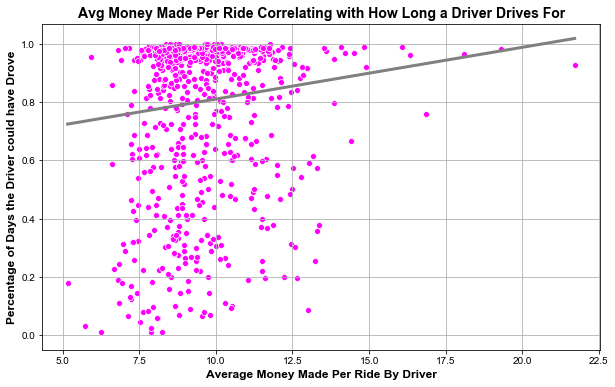

In [28]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Avg Money Made Per Ride Correlating with How Long a Driver Drives For', fontsize = 14, weight = 'bold')

x=updated_driver_data_df['avg_driver_value_per_ride']
y=updated_driver_data_df['percent_of_possible_drive_days']

sns.scatterplot(data=updated_driver_data_df, x=x, y=y, color = 'fuchsia')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='gray', linewidth=3.0)

plt.xlabel('Average Money Made Per Ride By Driver', fontsize = 12, weight = 'bold')
plt.ylabel('Percentage of Days the Driver could have Drove', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

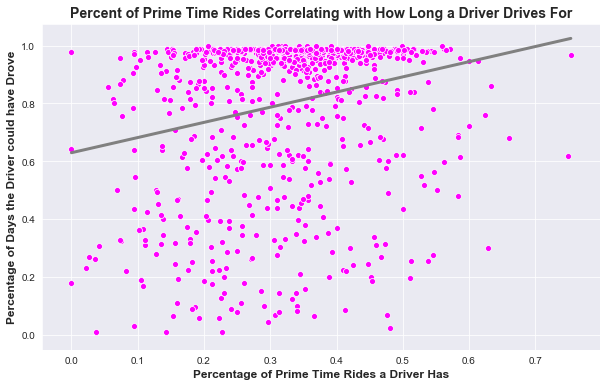

In [29]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Percent of Prime Time Rides Correlating with How Long a Driver Drives For', fontsize = 14, weight = 'bold')

x=updated_driver_data_df['percent_prime_time_rides']
y=updated_driver_data_df['percent_of_possible_drive_days']

sns.scatterplot(data=updated_driver_data_df, x=x, y=y, color = 'fuchsia')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='gray', linewidth=3.0)

plt.xlabel('Percentage of Prime Time Rides a Driver Has', fontsize = 12, weight = 'bold')
plt.ylabel('Percentage of Days the Driver could have Drove', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

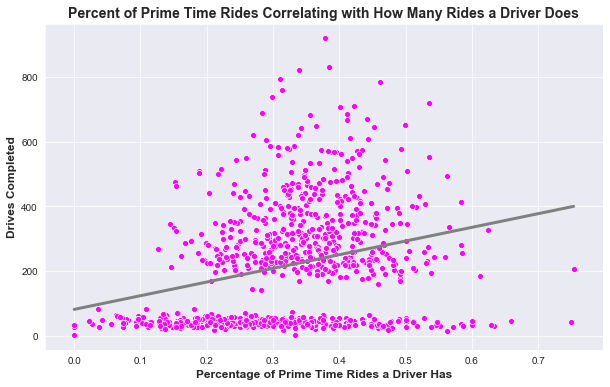

In [30]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Percent of Prime Time Rides Correlating with How Many Rides a Driver Does', fontsize = 14, weight = 'bold')

x=updated_driver_data_df['percent_prime_time_rides']
y=updated_driver_data_df['rides_given']

sns.scatterplot(data=updated_driver_data_df, x=x, y=y, color = 'fuchsia')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='gray', linewidth=3.0)

plt.xlabel('Percentage of Prime Time Rides a Driver Has', fontsize = 12, weight = 'bold')
plt.ylabel('Drives Completed', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

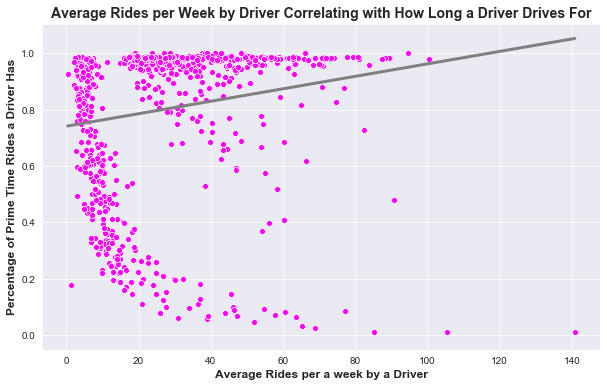

In [31]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Average Rides per Week by Driver Correlating with How Long a Driver Drives For', fontsize = 14, weight = 'bold')

x=updated_driver_data_df['avg_rides_in_week']
y=updated_driver_data_df['percent_of_possible_drive_days']

sns.scatterplot(data=updated_driver_data_df, x=x, y=y, color = 'fuchsia')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='gray', linewidth=3.0)

plt.xlabel('Average Rides per a week by a Driver', fontsize = 12, weight = 'bold')
plt.ylabel('Percentage of Prime Time Rides a Driver Has', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

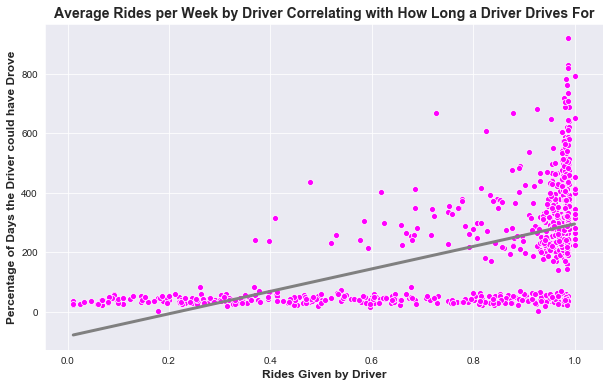

In [32]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Average Rides per Week by Driver Correlating with How Long a Driver Drives For', fontsize = 14, weight = 'bold')

x=updated_driver_data_df['percent_of_possible_drive_days']
y=updated_driver_data_df['rides_given']

sns.scatterplot(data=updated_driver_data_df, x=x, y=y, color = 'fuchsia')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='gray', linewidth=3.0)

plt.xlabel('Rides Given by Driver', fontsize = 12, weight = 'bold')
plt.ylabel('Percentage of Days the Driver could have Drove', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

## Segmentation of drivers by Clustering

In [34]:
# Function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={'index':cluster_field_name})
    return df_final

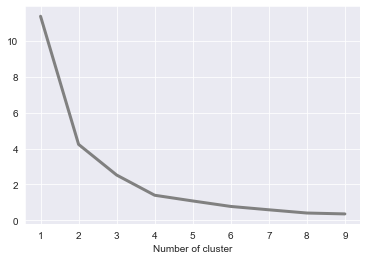

In [35]:
# Graph to find out how many clusters to cluster

sse={}
tx_recency = updated_driver_data_df[['percent_prime_time_rides']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color='gray', linewidth=3.0)
plt.xlabel('Number of cluster')
sns.set_style('darkgrid')
ax.grid('on')
plt.show()

In [36]:
#build 4 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=5)
kmeans.fit(updated_driver_data_df[['avg_rides_in_week']])
updated_driver_data_df['avg_rides_in_week_cluster'] = kmeans.predict(updated_driver_data_df[['avg_rides_in_week']])

updated_driver_data_df = order_cluster('avg_rides_in_week_cluster', 'avg_rides_in_week',updated_driver_data_df,True)

updated_driver_data_df.groupby('avg_rides_in_week_cluster')['avg_rides_in_week'].describe()

,count,mean,std,min,25%,50%,75%,max
avg_rides_in_week_cluster,,,,,,,,
0,289.0,7.598926,3.564997,0.324838,4.941135,6.767693,9.899749,16.053838
1,265.0,24.877333,4.400488,16.459958,21.294306,25.143917,28.480000,32.640607
2,178.0,40.510685,4.555614,32.845675,36.726474,40.036604,44.269533,49.575106
3,85.0,59.441445,6.786982,50.036352,53.979761,58.357103,63.836992,73.355701
4,20.0,88.018388,14.961734,74.157923,78.936261,84.532224,89.928246,140.804598


In [37]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(updated_driver_data_df[['percent_of_possible_drive_days']])
updated_driver_data_df['percent_of_possible_drive_days_cluster'] = kmeans.predict(updated_driver_data_df[['percent_of_possible_drive_days']])

updated_driver_data_df = order_cluster('percent_of_possible_drive_days_cluster', 'percent_of_possible_drive_days',updated_driver_data_df,True)

updated_driver_data_df.groupby('percent_of_possible_drive_days_cluster')['percent_of_possible_drive_days'].describe()

,count,mean,std,min,25%,50%,75%,max
percent_of_possible_drive_days_cluster,,,,,,,,
0,107.0,0.229944,0.108106,0.011111,0.146061,0.246154,0.319805,0.397260
1,113.0,0.564897,0.083978,0.400000,0.490196,0.584416,0.627907,0.689655
2,107.0,0.818873,0.052976,0.706897,0.778999,0.826087,0.861804,0.893333
3,510.0,0.970114,0.021629,0.895522,0.958904,0.978261,0.985865,1.000000


In [38]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(updated_driver_data_df[['percent_prime_time_rides']])
updated_driver_data_df['percent_prime_time_rides_cluster'] = kmeans.predict(updated_driver_data_df[['percent_prime_time_rides']])

updated_driver_data_df = order_cluster('percent_prime_time_rides_cluster', 'percent_prime_time_rides',updated_driver_data_df,True)

updated_driver_data_df.groupby('percent_prime_time_rides_cluster')['percent_prime_time_rides'].describe()

,count,mean,std,min,25%,50%,75%,max
percent_prime_time_rides_cluster,,,,,,,,
0,84.0,0.115985,0.043988,0.000000,0.093568,0.129331,0.153846,0.171429
1,178.0,0.228719,0.028729,0.175000,0.205882,0.229300,0.251175,0.275482
2,265.0,0.325512,0.025489,0.277778,0.303398,0.327824,0.347134,0.367713
3,226.0,0.411310,0.028298,0.368613,0.388412,0.410256,0.431707,0.468750
4,84.0,0.527552,0.056507,0.469512,0.490399,0.511370,0.547619,0.753623


In [39]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(updated_driver_data_df[['avg_driver_value_per_ride']])
updated_driver_data_df['avg_driver_value_per_ride_cluster'] = kmeans.predict(updated_driver_data_df[['avg_driver_value_per_ride']])

updated_driver_data_df = order_cluster('avg_driver_value_per_ride_cluster', 'avg_driver_value_per_ride',updated_driver_data_df,True)

updated_driver_data_df.groupby('avg_driver_value_per_ride_cluster')['avg_driver_value_per_ride'].describe()

,count,mean,std,min,25%,50%,75%,max
avg_driver_value_per_ride_cluster,,,,,,,,
0,150.0,7.737635,0.547889,5.159486,7.445394,7.907160,8.150030,8.331334
1,362.0,8.930884,0.340407,8.334031,8.674928,8.900398,9.215485,9.578119
2,222.0,10.249905,0.445316,9.592513,9.885743,10.200156,10.556226,11.206207
3,97.0,12.177974,0.897149,11.208723,11.510883,11.904826,12.589915,14.887820
4,6.0,18.067760,2.154744,16.091552,16.463252,17.477150,19.012859,21.710661


In [40]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(updated_driver_data_df[['total_lyft_value']])
updated_driver_data_df['total_lyft_value_cluster'] = kmeans.predict(updated_driver_data_df[['total_lyft_value']])

updated_driver_data_df = order_cluster('total_lyft_value_cluster', 'total_lyft_value',updated_driver_data_df,True)

updated_driver_data_df.groupby('total_lyft_value_cluster')['total_lyft_value'].describe()

,count,mean,std,min,25%,50%,75%,max
total_lyft_value_cluster,,,,,,,,
0,339.0,177.808237,68.282328,9.119614,132.248196,164.502638,210.382683,582.838273
1,283.0,1027.438241,174.975439,624.895513,893.501628,1023.475341,1175.561278,1338.570987
2,156.0,1654.560946,205.025820,1346.790744,1483.638780,1637.325977,1806.186989,2071.703384
3,59.0,2499.214915,379.044587,2090.226210,2207.871286,2382.918259,2697.800519,3756.366077


In [41]:
avg_rides_in_week_cluster = updated_driver_data_df['avg_rides_in_week_cluster']
percent_of_possible_drive_days_cluster = updated_driver_data_df['percent_of_possible_drive_days_cluster']
avg_driver_value_per_ride_cluster = updated_driver_data_df['avg_driver_value_per_ride_cluster']
percent_prime_time_rides_cluster = updated_driver_data_df['percent_prime_time_rides_cluster']
total_lyft_value_cluster = updated_driver_data_df['total_lyft_value_cluster']

updated_driver_data_df['overall_score'] = (avg_rides_in_week_cluster + percent_of_possible_drive_days_cluster
                                           + avg_driver_value_per_ride_cluster + percent_prime_time_rides_cluster + total_lyft_value_cluster)


clustering_data_df = updated_driver_data_df.groupby('overall_score')[['avg_driver_value_per_ride', 'percent_of_possible_drive_days',
                                                                      'avg_rides_in_week', 'percent_prime_time_rides', 'total_lyft_value', 
                                                                       'days_being_a_lyft_driver_int']].mean()

clustering_data_df

,avg_driver_value_per_ride,percent_of_possible_drive_days,avg_rides_in_week,percent_prime_time_rides,total_lyft_value,days_being_a_lyft_driver_int
overall_score,,,,,,
0,6.691643,0.243556,10.220618,0.090846,110.459721,19.750000
1,7.847506,0.347891,10.907488,0.128591,138.057954,26.294118
2,8.356944,0.437378,11.120778,0.183382,149.604545,31.850000
3,8.348639,0.452269,14.884374,0.236375,161.490597,31.162791
4,9.475085,0.530614,14.161316,0.257577,179.339916,37.333333
5,9.815201,0.663243,13.056224,0.273397,212.043581,42.919355
6,9.888365,0.757516,13.703583,0.309874,357.688869,53.431034
7,9.796762,0.832521,19.817958,0.325806,644.430397,59.384615
8,9.497582,0.904072,23.446745,0.345510,868.732471,64.252336


In [42]:
average_driver = updated_driver_data_df[['avg_driver_value_per_ride', 'percent_of_possible_drive_days', 
                                    'avg_rides_in_week', 'percent_prime_time_rides', 'total_lyft_value', 'days_being_a_lyft_driver_int']].mean()

average_driver

avg_driver_value_per_ride           9.508691
percent_of_possible_drive_days      0.801451
avg_rides_in_week                  27.254929
percent_prime_time_rides            0.327343
total_lyft_value                  903.951257
days_being_a_lyft_driver_int       55.105137
dtype: float64

In [43]:
len(updated_driver_data_df.loc[updated_driver_data_df['overall_score'] == 16])

2

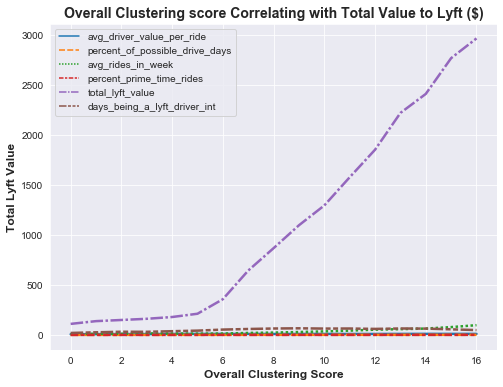

In [44]:
fig = plt.figure(figsize=[8,6])
ax = plt.subplot(111)
ax.set_title('Overall Clustering score Correlating with Total Value to Lyft ($)', fontsize = 14, weight = 'bold')

data = clustering_data_df
sns.lineplot(data=data, palette='tab10', linewidth=2.5)

plt.xlabel('Overall Clustering Score', fontsize = 12, weight = 'bold')
plt.ylabel('Total Lyft Value', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

#### High RFM score Correlates with a high Life Time Value

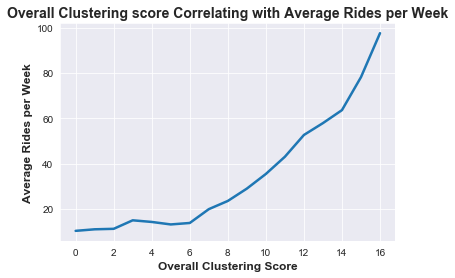

In [46]:
fig = plt.figure(figsize=[6,4])
ax = plt.subplot(111)
ax.set_title('Overall Clustering score Correlating with Average Rides per Week', fontsize = 14, weight = 'bold')

data = clustering_data_df['avg_rides_in_week']
sns.lineplot(data=data, palette='tab10', linewidth=2.5)

plt.xlabel('Overall Clustering Score', fontsize = 12, weight = 'bold')
plt.ylabel('Average Rides per Week', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

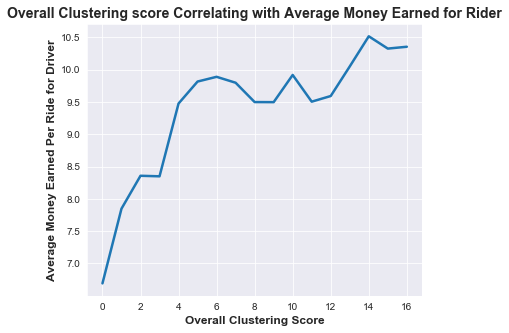

In [47]:
fig = plt.figure(figsize=[6, 5])
ax = plt.subplot(111)
ax.set_title('Overall Clustering score Correlating with Average Money Earned for Rider', fontsize = 14, weight = 'bold')

data = clustering_data_df['avg_driver_value_per_ride']
sns.lineplot(data=data, palette='tab10', linewidth=2.5)

plt.xlabel('Overall Clustering Score', fontsize = 12, weight = 'bold')
plt.ylabel('Average Money Earned Per Ride for Driver', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

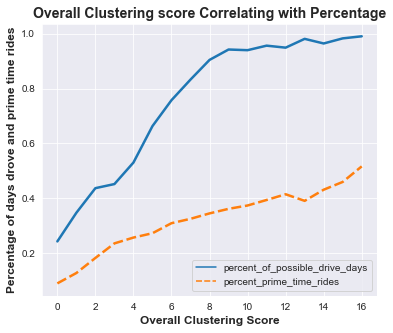

In [48]:
fig = plt.figure(figsize=[6, 5])
ax = plt.subplot(111)
ax.set_title('Overall Clustering score Correlating with Percentage', fontsize = 14, weight = 'bold')

data = clustering_data_df[['percent_of_possible_drive_days', 'percent_prime_time_rides']]
sns.lineplot(data=data, palette='tab10', linewidth=2.5)

plt.xlabel('Overall Clustering Score', fontsize = 12, weight = 'bold')
plt.ylabel('Percentage of days drove and prime time rides', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

In [49]:
updated_driver_data_df['segment_of_drivers'] = 'Low-Value'
updated_driver_data_df.loc[updated_driver_data_df['overall_score'] > 5, 'segment_of_drivers'] = 'Mid-Value'
updated_driver_data_df.loc[updated_driver_data_df['overall_score'] > 10, 'segment_of_drivers'] = 'High-Value'

In [50]:
updated_driver_data_df.head()

,driver_id,driver_onboard_date,total_distance,total_duration,total_prime_time,rides_given,avg_ride_distance,avg_ride_duration,first_ride_date,last_ride_date,...,total_lyft_value,percent_prime_time_rides,percent_of_possible_drive_days,avg_rides_in_week_cluster,percent_of_possible_drive_days_cluster,percent_prime_time_rides_cluster,avg_driver_value_per_ride_cluster,total_lyft_value_cluster,overall_score,segment_of_drivers
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,1081.364208,3687.300000,5375,277,3.903842,13.311552,2016-03-29 18:46:50,2016-06-23 10:29:53,...,1099.909253,0.397112,0.955556,1,3,3,1,1,9,Mid-Value
1,1d7bc6daa163020694e2a5e636b96a0d,2016-04-20,1150.785040,4017.500000,7900,301,3.823206,13.347176,2016-04-20 23:51:19,2016-06-23 22:23:49,...,1240.030954,0.375415,0.941176,1,3,3,1,1,9,Mid-Value
2,309320204754c3eeb2577949e870fe2d,2016-04-06,769.191049,2852.350000,3675,217,3.544659,13.144470,2016-04-06 07:17:00,2016-06-23 15:03:10,...,836.224896,0.368664,0.951220,1,3,3,1,1,9,Mid-Value
3,3b7f314bfe75abaa6718399d534ccf47,2016-04-01,1313.803636,4490.616667,6750,325,4.042473,13.817282,2016-04-01 19:52:40,2016-06-26 17:24:46,...,1315.303518,0.433846,0.988506,1,3,3,1,1,9,Mid-Value
4,3d2fa009a9f144706ad28ec9348f5960,2016-04-05,1200.500949,4941.050000,6650,312,3.847759,15.836699,2016-04-05 08:05:22,2016-06-26 11:47:48,...,1287.464243,0.381410,0.987952,1,3,3,1,1,9,Mid-Value


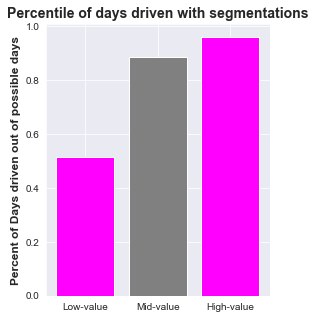

In [85]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['percent_of_possible_drive_days'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['percent_of_possible_drive_days'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['percent_of_possible_drive_days'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

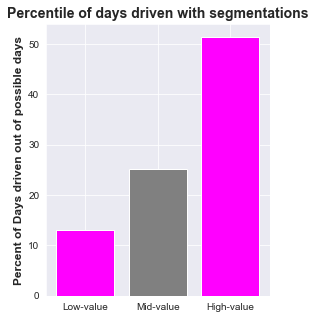

In [87]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['avg_rides_in_week'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['avg_rides_in_week'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['avg_rides_in_week'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

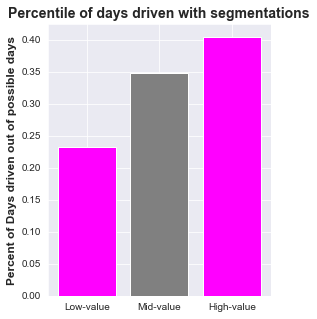

In [88]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['percent_prime_time_rides'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['percent_prime_time_rides'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['percent_prime_time_rides'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

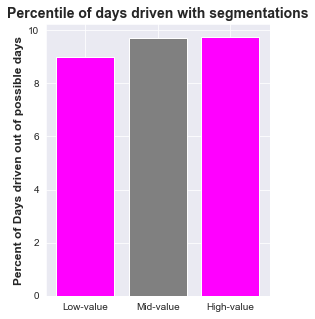

In [90]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['avg_driver_value_per_ride'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['avg_driver_value_per_ride'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['avg_driver_value_per_ride'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

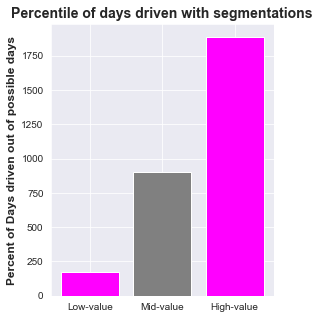

In [89]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['total_lyft_value'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['total_lyft_value'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['total_lyft_value'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

## Driver Lifetime Value Analysis

In [64]:
lifetime_value_df = updated_driver_data_df[['percent_prime_time_rides', 'avg_rides_in_week', 'percent_of_possible_drive_days', 
                                            'total_lyft_value', 'overall_score', 'segment_of_drivers', 'avg_driver_value_per_ride']]

lifetime_value_df['segment_of_drivers'] = 0
lifetime_value_df.loc[lifetime_value_df['overall_score'] > 5, 'segment_of_drivers'] = 1
lifetime_value_df.loc[lifetime_value_df['overall_score'] > 10, 'segment_of_drivers'] = 2
lifetime_value_df.head()

,percent_prime_time_rides,avg_rides_in_week,percent_of_possible_drive_days,total_lyft_value,overall_score,segment_of_drivers,avg_driver_value_per_ride
0,0.397112,22.432414,0.955556,1099.909253,9,1,8.883166
1,0.375415,32.448729,0.941176,1240.030954,9,1,9.478817
2,0.368664,19.319015,0.951220,836.224896,9,1,8.414284
3,0.433846,26.232183,0.988506,1315.303518,9,1,9.188351
4,0.381410,26.475446,0.987952,1287.464243,9,1,9.505952


In [65]:
#create X and y, X will be feature set and y is the label - LTV
y = lifetime_value_df['segment_of_drivers']
X = lifetime_value_df.drop(['segment_of_drivers', 'overall_score', 'total_lyft_value'],axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [67]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.91


In [68]:
y_pred = ltv_xgb_model.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.92      0.91      0.91        85
           2       0.88      0.86      0.87        35

    accuracy                           0.91       168
   macro avg       0.91      0.91      0.91       168
weighted avg       0.91      0.91      0.91       168



In [70]:
importances = pd.DataFrame({
    'features': lifetime_value_df.drop(['segment_of_drivers', 'overall_score', 'total_lyft_value'], axis=1).columns,
    'importance': ltv_xgb_model.feature_importances_
})

importances = importances.sort_values(by='importance', ascending=False)

importances

,features,importance
1,avg_rides_in_week,0.421947
2,percent_of_possible_drive_days,0.248210
0,percent_prime_time_rides,0.197864
3,avg_driver_value_per_ride,0.131979


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

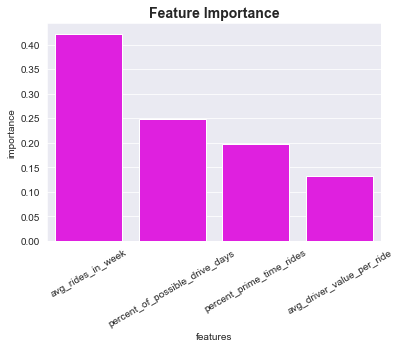

In [71]:
fig = plt.figure(figsize=[6,4])
ax = plt.subplot(111)
ax.set_title('Feature Importance', fontsize = 14, weight = 'bold')

sns.barplot(x=importances['features'], y=importances['importance'], color='fuchsia')

plt.xticks(rotation=30)

## Churn Rate

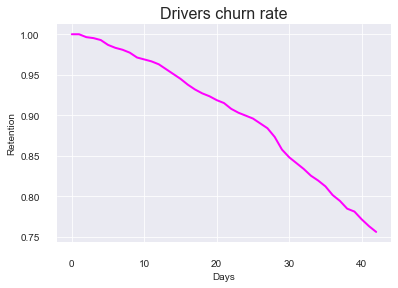

In [53]:
retention_rates_by_day = []

for i in range(43):
    retention = (updated_driver_data_df['days_being_a_lyft_driver_int'] >= i).mean()
    retention_rates_by_day.append(retention)
    
plt.plot(retention_rates_by_day, color='fuchsia', linewidth=2.0)

plt.title('Drivers churn rate', fontsize = 16)

plt.xlabel('Days')
plt.ylabel('Retention')
sns.despine(offset=10)

In [55]:
# Driver churn rate is ~24% over 42 days (after 42 days, only 76% of the onboarded drivers are active)
# 0.57% churn rate per day

In [58]:
# Average Projected Life time of a driver

(updated_driver_data_df['days_being_a_lyft_driver_int'] / 0.57).mean()

96.67567964115786

In [59]:
updated_driver_data_df['projected_lifetime'] = (updated_driver_data_df['days_being_a_lyft_driver_int'] / 0.57)

In [92]:
# Low-Value Drivers

low_lifetime = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['projected_lifetime'].mean()
low_weekly_rides = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['avg_rides_in_week'].mean()
low_lyft_value = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['avg_lyft_value_per_ride'].mean()

low_driver_value = (low_lifetime / 7) * low_weekly_rides * low_lyft_value

print(f'Average Projected Lifetime of a Driver: {low_lifetime}')
print(f'Average Rides given a week by a Driver: {low_weekly_rides}')
print(f'Average Value to Lyft per Ride by a Driver: {low_lyft_value}')
print(f'Life time value to Lyft over the entire projected lifetime of a driver: {low_driver_value}')

Average Projected Lifetime of a Driver: 62.460736995326755
Average Rides given a week by a Driver: 13.156409374812755
Average Value to Lyft per Ride by a Driver: 3.997725153783273
Life time value to Lyft over the entire projected lifetime of a driver: 469.30953252018645


In [93]:
# Mid-Value Drivers

low_lifetime = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['projected_lifetime'].mean()
low_weekly_rides = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['avg_rides_in_week'].mean()
low_lyft_value = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['avg_lyft_value_per_ride'].mean()

mid_driver_value = (low_lifetime / 7) * low_weekly_rides * low_lyft_value

print(f'Average Projected Lifetime of a Driver: {low_lifetime}')
print(f'Average Rides given a week by a Driver: {low_weekly_rides}')
print(f'Average Value to Lyft per Ride by a Driver: {low_lyft_value}')
print(f'Life time value to Lyft over the entire projected lifetime of a driver: {mid_driver_value}')

Average Projected Lifetime of a Driver: 109.2645998558039
Average Rides given a week by a Driver: 25.25658158697183
Average Value to Lyft per Ride by a Driver: 4.171885860835839
Life time value to Lyft over the entire projected lifetime of a driver: 1644.7065696327709


In [94]:
# High-Value Drivers

low_lifetime = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['projected_lifetime'].mean()
low_weekly_rides = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['avg_rides_in_week'].mean()
low_lyft_value = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['avg_lyft_value_per_ride'].mean()

high_driver_value = (low_lifetime / 7) * low_weekly_rides * low_lyft_value

print(f'Average Projected Lifetime of a Driver: {low_lifetime}')
print(f'Average Rides given a week by a Driver: {low_weekly_rides}')
print(f'Average Value to Lyft per Ride by a Driver: {low_lyft_value}')
print(f'Life time value to Lyft over the entire projected lifetime of a driver: {high_driver_value}')

Average Projected Lifetime of a Driver: 110.33023735810114
Average Rides given a week by a Driver: 51.395145633838226
Average Value to Lyft per Ride by a Driver: 4.186343710597505
Life time value to Lyft over the entire projected lifetime of a driver: 3391.200719988387


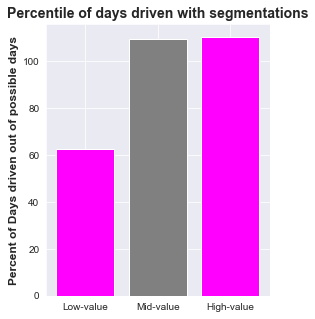

In [91]:
low_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Low-Value']['projected_lifetime'].mean()
mid_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'Mid-Value']['projected_lifetime'].mean()
high_possible_drive_days = updated_driver_data_df.loc[updated_driver_data_df['segment_of_drivers'] == 'High-Value']['projected_lifetime'].mean()

fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_possible_drive_days, mid_possible_drive_days, high_possible_drive_days]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')

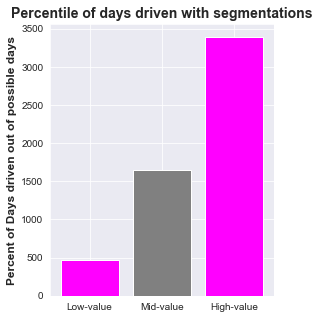

In [96]:
fig = plt.figure(figsize=[4,5])
plt.title('Percentile of days driven with segmentations', fontsize = 14, weight = 'bold')

x = [low_driver_value, mid_driver_value, high_driver_value]
plt.bar(x = ('Low-value', 'Mid-value', 'High-value'), height = x, align='center', color=('fuchsia', 'gray', 'fuchsia'))

plt.ylabel('Percent of Days driven out of possible days', fontsize = 12, weight = 'bold')
sns.set_style('darkgrid')
ax.grid('on')